In [1]:
#The only thing to include in the paper/presentation from this code is the bar graph

import numpy as np
from matplotlib import pyplot as plt
from sklearn import preprocessing
#import wfdb
import copy as cp
import scipy.signal as signal
import pickle
from sklearn import preprocessing
from tqdm import tqdm
import os
import re
import pandas as pd
import csv

from sklearn.linear_model import LogisticRegression
from sklearn import neighbors
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis 
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from time import time
import timeit

import random
random.seed(1000)

In [2]:
%matplotlib inline
plt.rcParams['figure.dpi'] = 70 #display 70 dpi in Jupyter Notebook, may consider100 dpi 
plt.rcParams['savefig.dpi'] = 300 #define 300 dpi for saving figures

import seaborn as sns
## here are some settings 
sns.set_style('whitegrid')
sns.set(rc={"figure.dpi":70, 'savefig.dpi':300}) #defining dpi setting
sns.set_context('notebook')
sns.set_style("ticks")
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

#sns.set(rc={'figure.figsize':(11.7,8.27)})

C:\Users\bhoom\AppData\Local\Temp/ipykernel_50796/3159236473.py:12: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('retina')


# Side to side comparison plots

In [3]:
statallfeatures_dic = {
    'Run Time': [],
    'Accuracy': [],   ## To store the MEAN accuracy for 5-fold CV for each model
    'Standard Error': [],
    'Sensitivity': [],
    'Specificity': [],
    'Precision': [],
    'F1_Score': []   
}

In [4]:
## To store the accuracy for 5-fold CV for each model
indaccs_dic = {}

2017 train -> 2021 test

In [5]:
test_df = pd.read_csv('JORN17_dataset_v2.csv', na_values='?').dropna()
train_df = pd.read_csv('SRER21_dataset_v1.csv', na_values='?').dropna()
train_df.head()
test_df.head()

,OID_,Id,gridcode,Shape_Length,Shape_Area,CH_mean,ARVI_mean,ARVI_med,ARVI_max,EVI_mean,EVI_med,EVI_max,NDVI_mean,NDVI_med,NDVI_max,SAVI_mean,SAVI_med,SAVI_max,Veg_class
0,2,2,2,16.0,4.79,0.0100,0.223962,0.226896,0.239161,0.273236,0.274394,0.307885,0.402131,0.406066,0.427636,0.278782,0.280285,0.316995,woody
1,3,3,3,8.6,2.24,0.0100,0.287822,0.287822,0.316384,0.302193,0.302193,0.305906,0.448325,0.448325,0.469259,0.301407,0.301407,0.304224,woody
2,4,4,4,27.8,11.12,0.0125,0.289236,0.313074,0.459671,0.300200,0.318621,0.374641,0.447470,0.466219,0.570786,0.298798,0.314429,0.358302,woody
3,5,5,5,24.2,10.62,0.0600,0.330255,0.375986,0.498250,0.313174,0.335601,0.386369,0.477596,0.517136,0.598966,0.309534,0.325886,0.368766,woody
4,6,6,6,17.4,6.10,0.0120,0.275800,0.341526,0.416294,0.264112,0.280268,0.314841,0.431575,0.487791,0.518614,0.266352,0.273629,0.312146,woody


In [6]:
#Logistic Regression

kf = KFold(n_splits=5, random_state=3, shuffle=True)
model = LogisticRegression(solver='liblinear')

start_time = timeit.default_timer()

acc_score = []
Truth = []
Output = []

testindex8 = []
testindex9 = []

for train_index, test_index in kf.split(test_df): 
    X_train = train_df.iloc[train_index, 5:18]
    X_test = test_df.iloc[test_index, 5:18]
    Y_train = train_df.iloc[train_index, -1]
    Y_test = test_df.iloc[test_index, -1]

    model.fit(X_train, Y_train)
    pred_values = model.predict(X_test)

    acc = accuracy_score(Y_test, pred_values)
    acc_score.append(acc)

    Truth.extend(Y_test.values.reshape(Y_test.shape[0])) 
    Output.extend(pred_values)
    
    testindex8.append(test_index)
    testindex9.append(pred_values)

elapsed = timeit.default_timer() - start_time



print("---Run time is %s seconds ---" % elapsed)
print()
print('Accuracy of each fold: \n {}'.format(acc_score))
print("Avg accuracy: {}".format(np.mean(acc_score)))
print('Std of accuracy : \n{}'.format(np.std(acc_score)))
print()
print(confusion_matrix(Truth, Output))
print()
print(classification_report(Truth, Output))

cm = confusion_matrix(Truth, Output)

sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])
specificity = cm[1][1]/(cm[1][0]+cm[1][1])
precision = (cm[0][0])/(cm[0][0]+cm[1][0])
f1_score = (2*precision*sensitivity)/(precision+sensitivity)

print(sensitivity)
print(specificity)
print(precision)
print(f1_score)

statallfeatures_dic['Run Time'].append(elapsed)
statallfeatures_dic['Accuracy'].append(np.mean(acc_score))
statallfeatures_dic['Standard Error'].append(np.std(acc_score))
statallfeatures_dic['Sensitivity'].append(sensitivity)
statallfeatures_dic['Specificity'].append(specificity)
statallfeatures_dic['Precision'].append(precision)
statallfeatures_dic['F1_Score'].append(f1_score)

indaccs_dic['LogReg']=acc_score

---Run time is 0.050082699999999925 seconds ---

Accuracy of each fold: 
 [0.569811320754717, 0.6018867924528302, 0.5566037735849056, 0.6, 0.5784499054820416]
Avg accuracy: 0.5813503584548988
Std of accuracy : 
0.01745571386299571

[[ 942   35]
 [1074  598]]

              precision    recall  f1-score   support

   non-woody       0.47      0.96      0.63       977
       woody       0.94      0.36      0.52      1672

    accuracy                           0.58      2649
   macro avg       0.71      0.66      0.57      2649
weighted avg       0.77      0.58      0.56      2649

0.9641760491299898
0.3576555023923445
0.46726190476190477
0.6294687604410291


In [7]:
"""
woodyarea1 = 0
nonwoodyarea1 = 0
totalarea1 = 0

start_time = timeit.default_timer()

for i in testindex8:
    for j in i:
        totalarea1 += test_df.iat[j,4]
        if test_df.iat[j,-1] == "woody":
            woodyarea1 += test_df.iat[j,4]
        if test_df.iat[j,-1] == "non-woody":
            nonwoodyarea1 += test_df.iat[j,4]

elapsed = timeit.default_timer() - start_time
print("---Run time is %s seconds ---" % elapsed)
needed = woodyarea1/totalarea1 * 100
print(needed)

woodyarea4 = 0
nonwoodyarea4 = 0
totalarea4 = 0

start_time = timeit.default_timer()

for i in testindex8:
    for j in i:
        for k in range(0,5):
            for l in testindex9[k]:
                if l == "woody":
                    woodyarea4 += test_df.iat[j,4]
                    totalarea4 += test_df.iat[j,4]
                if l == "non-woody":
                    nonwoodyarea4 += test_df.iat[j,4]
                    totalarea4 += test_df.iat[j,4]
elapsed = timeit.default_timer() - start_time
print("---Run time is %s seconds ---" % elapsed)
FWC4 = woodyarea4/totalarea4 * 100
                    
print(FWC4)
"""

'\nwoodyarea1 = 0\nnonwoodyarea1 = 0\ntotalarea1 = 0\n\nstart_time = timeit.default_timer()\n\nfor i in testindex8:\n    for j in i:\n        totalarea1 += test_df.iat[j,4]\n        if test_df.iat[j,-1] == "woody":\n            woodyarea1 += test_df.iat[j,4]\n        if test_df.iat[j,-1] == "non-woody":\n            nonwoodyarea1 += test_df.iat[j,4]\n\nelapsed = timeit.default_timer() - start_time\nprint("---Run time is %s seconds ---" % elapsed)\nneeded = woodyarea1/totalarea1 * 100\nprint(needed)\n\nwoodyarea4 = 0\nnonwoodyarea4 = 0\ntotalarea4 = 0\n\nstart_time = timeit.default_timer()\n\nfor i in testindex8:\n    for j in i:\n        for k in range(0,5):\n            for l in testindex9[k]:\n                if l == "woody":\n                    woodyarea4 += test_df.iat[j,4]\n                    totalarea4 += test_df.iat[j,4]\n                if l == "non-woody":\n                    nonwoodyarea4 += test_df.iat[j,4]\n                    totalarea4 += test_df.iat[j,4]\nelapsed = ti

In [8]:
#LDA
kf = KFold(n_splits=5, random_state=3, shuffle=True)
model=LinearDiscriminantAnalysis()

acc_score = []
Truth = []
Output = []

testindex1 = []
testindex2 = []
  
for train_index, test_index in kf.split(test_df): 
    X_train = train_df.iloc[train_index, 5:18]
    X_test = test_df.iloc[test_index, 5:18]
    Y_train = train_df.iloc[train_index, -1]
    Y_test = test_df.iloc[test_index, -1]


    model.fit(X_train, Y_train)
    pred_values = model.predict(X_test)

    acc = accuracy_score(Y_test, pred_values)
    acc_score.append(acc)

    Truth.extend(Y_test.values.reshape(Y_test.shape[0])) 
    Output.extend(pred_values)
    
    testindex1.append(test_index)
    testindex2.append(pred_values)

elapsed = timeit.default_timer() - start_time



print("---Run time is %s seconds ---" % elapsed)
print()
print('Accuracy of each fold: \n {}'.format(acc_score))
print("Avg accuracy: {}".format(np.mean(acc_score)))
print('Std of accuracy : \n{}'.format(np.std(acc_score)))
print()
print(confusion_matrix(Truth, Output))
print()
print(classification_report(Truth, Output))

cm = confusion_matrix(Truth, Output)

sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])
specificity = cm[1][1]/(cm[1][0]+cm[1][1])
precision = (cm[0][0])/(cm[0][0]+cm[1][0])
f1_score = (2*precision*sensitivity)/(precision+sensitivity)

print(sensitivity)
print(specificity)
print(precision)
print(f1_score)

statallfeatures_dic['Run Time'].append(elapsed)
statallfeatures_dic['Accuracy'].append(np.mean(acc_score))
statallfeatures_dic['Standard Error'].append(np.std(acc_score))
statallfeatures_dic['Sensitivity'].append(sensitivity)
statallfeatures_dic['Specificity'].append(specificity)
statallfeatures_dic['Precision'].append(precision)
statallfeatures_dic['F1_Score'].append(f1_score)

indaccs_dic['LDA']=acc_score

---Run time is 0.22408040000000007 seconds ---

Accuracy of each fold: 
 [0.5490566037735849, 0.5528301886792453, 0.5981132075471698, 0.569811320754717, 0.5595463137996219]
Avg accuracy: 0.5658715269108677
Std of accuracy : 
0.01759474017808908

[[ 416  561]
 [ 589 1083]]

              precision    recall  f1-score   support

   non-woody       0.41      0.43      0.42       977
       woody       0.66      0.65      0.65      1672

    accuracy                           0.57      2649
   macro avg       0.54      0.54      0.54      2649
weighted avg       0.57      0.57      0.57      2649

0.4257932446264074
0.6477272727272727
0.41393034825870645
0.41977800201816345


In [9]:
"""
woodyarea1 = 0
nonwoodyarea1 = 0
totalarea1 = 0

start_time = timeit.default_timer()

for i in testindex1:
    for j in i:
        totalarea1 += test_df.iat[j,4]
        if test_df.iat[j,-1] == "woody":
            woodyarea1 += test_df.iat[j,4]
        if test_df.iat[j,-1] == "non-woody":
            nonwoodyarea1 += test_df.iat[j,4]

elapsed = timeit.default_timer() - start_time
print("---Run time is %s seconds ---" % elapsed)
print(woodyarea1/totalarea1 * 100)

needed2 = woodyarea1/totalarea1 * 100
print(needed2)

woodyarea1 = 0
nonwoodyarea1 = 0
totalarea1 = 0
start_time = timeit.default_timer()

for i in testindex1:
    for j in i:
        for k in range(0,5):
            for l in testindex2[k]:
                if l == "woody":
                    woodyarea1 += test_df.iat[j,4]
                    totalarea1 += test_df.iat[j,4]
                if l == "non-woody":
                    nonwoodyarea1 += test_df.iat[j,4]
                    totalarea1 += test_df.iat[j,4]

                    
elapsed = timeit.default_timer() - start_time
print("---Run time is %s seconds ---" % elapsed)
FWC = woodyarea1/totalarea1 * 100
                    
print(FWC)
"""

'\nwoodyarea1 = 0\nnonwoodyarea1 = 0\ntotalarea1 = 0\n\nstart_time = timeit.default_timer()\n\nfor i in testindex1:\n    for j in i:\n        totalarea1 += test_df.iat[j,4]\n        if test_df.iat[j,-1] == "woody":\n            woodyarea1 += test_df.iat[j,4]\n        if test_df.iat[j,-1] == "non-woody":\n            nonwoodyarea1 += test_df.iat[j,4]\n\nelapsed = timeit.default_timer() - start_time\nprint("---Run time is %s seconds ---" % elapsed)\nprint(woodyarea1/totalarea1 * 100)\n\nneeded2 = woodyarea1/totalarea1 * 100\nprint(needed2)\n\nwoodyarea1 = 0\nnonwoodyarea1 = 0\ntotalarea1 = 0\nstart_time = timeit.default_timer()\n\nfor i in testindex1:\n    for j in i:\n        for k in range(0,5):\n            for l in testindex2[k]:\n                if l == "woody":\n                    woodyarea1 += test_df.iat[j,4]\n                    totalarea1 += test_df.iat[j,4]\n                if l == "non-woody":\n                    nonwoodyarea1 += test_df.iat[j,4]\n                    totala

In [10]:
#QDA
kf = KFold(n_splits=5, random_state=3, shuffle=True)
model=QuadraticDiscriminantAnalysis()

acc_score = []
Truth = []
Output = []

testindex3 = []
testindex4 = []


for train_index, test_index in kf.split(test_df): 
    X_train = train_df.iloc[train_index, 5:18]
    X_test = test_df.iloc[test_index, 5:18]
    Y_train = train_df.iloc[train_index, -1]
    Y_test = test_df.iloc[test_index, -1]


    model.fit(X_train, Y_train)
    pred_values = model.predict(X_test)


    acc = accuracy_score(Y_test, pred_values)
    acc_score.append(acc)

    Truth.extend(Y_test.values.reshape(Y_test.shape[0])) 
    Output.extend(pred_values)
    
    testindex3.append(test_index)
    testindex4.append(pred_values)

elapsed = timeit.default_timer() - start_time


print("---Run time is %s seconds ---" % elapsed)
print()
print('Accuracy of each fold: \n {}'.format(acc_score))
print("Avg accuracy: {}".format(np.mean(acc_score)))
print('Std of accuracy : \n{}'.format(np.std(acc_score)))
print()
print(confusion_matrix(Truth, Output))
print()
print(classification_report(Truth, Output))

cm = confusion_matrix(Truth, Output)

sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])
specificity = cm[1][1]/(cm[1][0]+cm[1][1])
precision = (cm[0][0])/(cm[0][0]+cm[1][0])
f1_score = (2*precision*sensitivity)/(precision+sensitivity)

print(sensitivity)
print(specificity)
print(precision)
print(f1_score)

statallfeatures_dic['Run Time'].append(elapsed)
statallfeatures_dic['Accuracy'].append(np.mean(acc_score))
statallfeatures_dic['Standard Error'].append(np.std(acc_score))
statallfeatures_dic['Sensitivity'].append(sensitivity)
statallfeatures_dic['Specificity'].append(specificity)
statallfeatures_dic['Precision'].append(precision)
statallfeatures_dic['F1_Score'].append(f1_score)

indaccs_dic['QDA']=acc_score

---Run time is 0.34389179999999975 seconds ---

Accuracy of each fold: 
 [0.6056603773584905, 0.5660377358490566, 0.6396226415094339, 0.6283018867924528, 0.5992438563327032]
Avg accuracy: 0.6077732995684274
Std of accuracy : 
0.025514217983861172

[[ 135  842]
 [ 197 1475]]

              precision    recall  f1-score   support

   non-woody       0.41      0.14      0.21       977
       woody       0.64      0.88      0.74      1672

    accuracy                           0.61      2649
   macro avg       0.52      0.51      0.47      2649
weighted avg       0.55      0.61      0.54      2649

0.13817809621289662
0.882177033492823
0.4066265060240964
0.20626432391138272


In [11]:
"""
woodyarea1 = 0
nonwoodyarea1 = 0
totalarea1 = 0

start_time = timeit.default_timer()

for i in testindex3:
    for j in i:
        totalarea1 += test_df.iat[j,4]
        if test_df.iat[j,-1] == "woody":
            woodyarea1 += test_df.iat[j,4]
        if test_df.iat[j,-1] == "non-woody":
            nonwoodyarea1 += test_df.iat[j,4]

elapsed = timeit.default_timer() - start_time
print("---Run time is %s seconds ---" % elapsed)
needed3 = woodyarea1/totalarea1 * 100
print(needed3)
woodyarea2 = 0
nonwoodyarea2 = 0
totalarea2 = 0
start_time = timeit.default_timer()

for i in testindex3:
    for j in i:
        for k in range(0,5):
            for l in testindex4[k]:
                if l == "woody":
                    woodyarea2 += test_df.iat[j,4]
                    totalarea2 += test_df.iat[j,4]
                if l == "non-woody":
                    nonwoodyarea2 += test_df.iat[j,4]
                    totalarea2 += test_df.iat[j,4]
elapsed = timeit.default_timer() - start_time
print("---Run time is %s seconds ---" % elapsed)
FWC2 = woodyarea2/totalarea2 * 100
                    
print(FWC2)
"""

'\nwoodyarea1 = 0\nnonwoodyarea1 = 0\ntotalarea1 = 0\n\nstart_time = timeit.default_timer()\n\nfor i in testindex3:\n    for j in i:\n        totalarea1 += test_df.iat[j,4]\n        if test_df.iat[j,-1] == "woody":\n            woodyarea1 += test_df.iat[j,4]\n        if test_df.iat[j,-1] == "non-woody":\n            nonwoodyarea1 += test_df.iat[j,4]\n\nelapsed = timeit.default_timer() - start_time\nprint("---Run time is %s seconds ---" % elapsed)\nneeded3 = woodyarea1/totalarea1 * 100\nprint(needed3)\nwoodyarea2 = 0\nnonwoodyarea2 = 0\ntotalarea2 = 0\nstart_time = timeit.default_timer()\n\nfor i in testindex3:\n    for j in i:\n        for k in range(0,5):\n            for l in testindex4[k]:\n                if l == "woody":\n                    woodyarea2 += test_df.iat[j,4]\n                    totalarea2 += test_df.iat[j,4]\n                if l == "non-woody":\n                    nonwoodyarea2 += test_df.iat[j,4]\n                    totalarea2 += test_df.iat[j,4]\nelapsed = time

#KNN-CV
KNN_result = []
X=subject_df.iloc[:, 2:17]
Y=subject_df.iloc[:, -1]
crossvalidation = KFold(n_splits=5, random_state=3, shuffle=True)
KNNResult = []
for k in range(1,26):
    knn = neighbors.KNeighborsClassifier(n_neighbors=k)
    model = knn.fit(X, Y)
    scores=cross_val_score(model, X, Y, cv=crossvalidation)
    print('K={}'.format(k))
    print()
    print('Accuracy of each fold: \n {}'.format(scores))
    print()
    print("Avg accuracy: {}".format(scores.mean()))
    print()
    KNN_result.append(scores.mean())
print(KNN_result)

In [12]:
KNN_result = []
X=train_df.iloc[:, 5:18]
Y=train_df.iloc[:, -1]
crossvalidation = KFold(n_splits=5, random_state=3, shuffle=True)
KNNResult = []
for k in range(1,11):
    knn = neighbors.KNeighborsClassifier(n_neighbors=k)
    model = knn.fit(X, Y)
    scores=cross_val_score(model, X, Y, cv=crossvalidation)
    print('K={}'.format(k))
    print()
    print('Accuracy of each fold: \n {}'.format(scores))
    print()
    print("Avg accuracy: {}".format(scores.mean()))
    print()
    KNN_result.append(scores.mean())
print(KNN_result)

K=1

Accuracy of each fold: 
 [0.82365907 0.808964   0.81116826 0.81410727 0.80749449]

Avg accuracy: 0.813078618662748

K=2

Accuracy of each fold: 
 [0.81337252 0.80529023 0.80969875 0.79500367 0.8199853 ]

Avg accuracy: 0.8086700955180015

K=3

Accuracy of each fold: 
 [0.84937546 0.82953711 0.84349743 0.82880235 0.84349743]

Avg accuracy: 0.8389419544452608

K=4

Accuracy of each fold: 
 [0.84276267 0.82586334 0.85084497 0.8185158  0.84055841]

Avg accuracy: 0.8357090374724467

K=5

Accuracy of each fold: 
 [0.85819251 0.83541514 0.85525349 0.83247612 0.84790595]

Avg accuracy: 0.8458486407053638

K=6

Accuracy of each fold: 
 [0.85304923 0.8376194  0.85745775 0.82733284 0.84129317]

Avg accuracy: 0.8433504775900074

K=7

Accuracy of each fold: 
 [0.85819251 0.8376194  0.86480529 0.84202792 0.85378398]

Avg accuracy: 0.8512858192505511

K=8

Accuracy of each fold: 
 [0.856723   0.83468038 0.86333578 0.83688464 0.84570169]

Avg accuracy: 0.8474650991917707

K=9

Accuracy of each fol

In [13]:
#KNN-CV
kf = KFold(n_splits=5, random_state=3, shuffle=True)
model=neighbors.KNeighborsClassifier(n_neighbors=9)

acc_score = []
Truth = []
Output = []

testindex5 = []
testindex6 = []

for train_index, test_index in kf.split(test_df): 
    X_train = train_df.iloc[train_index, 5:18]
    X_test = test_df.iloc[test_index, 5:18]
    Y_train = train_df.iloc[train_index, -1]
    Y_test = test_df.iloc[test_index, -1]

    model.fit(X_train, Y_train)
    pred_values = model.predict(X_test)

    acc = accuracy_score(Y_test, pred_values)
    acc_score.append(acc)

    Truth.extend(Y_test.values.reshape(Y_test.shape[0])) 
    Output.extend(pred_values)
    
    testindex5.append(test_index)
    testindex6.append(pred_values)

elapsed = timeit.default_timer() - start_time

print()
print("---Run time is %s seconds ---" % elapsed)
print()
print('Accuracy of each fold: \n {}'.format(acc_score))
print("Avg accuracy: {}".format(np.mean(acc_score)))
print('Std of accuracy : \n{}'.format(np.std(acc_score)))
print()
print(confusion_matrix(Truth, Output))
print()
print(classification_report(Truth, Output))

cm = confusion_matrix(Truth, Output)

sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])
specificity = cm[1][1]/(cm[1][0]+cm[1][1])
precision = (cm[0][0])/(cm[0][0]+cm[1][0])
f1_score = (2*precision*sensitivity)/(precision+sensitivity)

print(sensitivity)
print(specificity)
print(precision)
print(f1_score)

statallfeatures_dic['Run Time'].append(elapsed)
statallfeatures_dic['Accuracy'].append(np.mean(acc_score))
statallfeatures_dic['Standard Error'].append(np.std(acc_score))
statallfeatures_dic['Sensitivity'].append(sensitivity)
statallfeatures_dic['Specificity'].append(specificity)
statallfeatures_dic['Precision'].append(precision)
statallfeatures_dic['F1_Score'].append(f1_score)

indaccs_dic['KNN']=acc_score


---Run time is 3.6964336000000007 seconds ---

Accuracy of each fold: 
 [0.5886792452830188, 0.5471698113207547, 0.5584905660377358, 0.5547169811320755, 0.5463137996219282]
Avg accuracy: 0.5590740806791026
Std of accuracy : 
0.015494043879107574

[[748 229]
 [939 733]]

              precision    recall  f1-score   support

   non-woody       0.44      0.77      0.56       977
       woody       0.76      0.44      0.56      1672

    accuracy                           0.56      2649
   macro avg       0.60      0.60      0.56      2649
weighted avg       0.64      0.56      0.56      2649

0.7656090071647902
0.4383971291866029
0.44339063426200354
0.5615615615615616


In [14]:
"""
woodyarea1 = 0
nonwoodyarea1 = 0
totalarea1 = 0

start_time = timeit.default_timer()

for i in testindex5:
    for j in i:
        totalarea1 += test_df.iat[j,4]
        if test_df.iat[j,-1] == "woody":
            woodyarea1 += test_df.iat[j,4]
        if test_df.iat[j,-1] == "non-woody":
            nonwoodyarea1 += test_df.iat[j,4]

elapsed = timeit.default_timer() - start_time
print("---Run time is %s seconds ---" % elapsed)
needed4 = woodyarea1/totalarea1 * 100
print(needed4)
woodyarea3 = 0
nonwoodyarea3 = 0
totalarea3 = 0

start_time = timeit.default_timer()

for i in testindex5:
    for j in i:
        for k in range(0,5):
            for l in testindex6[k]:
                if l == "woody":
                    woodyarea3 += test_df.iat[j,4]
                    totalarea3 += test_df.iat[j,4]
                if l == "non-woody":
                    nonwoodyarea3 += test_df.iat[j,4]
                    totalarea3 += test_df.iat[j,4]

elapsed = timeit.default_timer() - start_time
print("---Run time is %s seconds ---" % elapsed)
FWC3 = woodyarea3/totalarea3 * 100
                    
print(FWC3)
"""

'\nwoodyarea1 = 0\nnonwoodyarea1 = 0\ntotalarea1 = 0\n\nstart_time = timeit.default_timer()\n\nfor i in testindex5:\n    for j in i:\n        totalarea1 += test_df.iat[j,4]\n        if test_df.iat[j,-1] == "woody":\n            woodyarea1 += test_df.iat[j,4]\n        if test_df.iat[j,-1] == "non-woody":\n            nonwoodyarea1 += test_df.iat[j,4]\n\nelapsed = timeit.default_timer() - start_time\nprint("---Run time is %s seconds ---" % elapsed)\nneeded4 = woodyarea1/totalarea1 * 100\nprint(needed4)\nwoodyarea3 = 0\nnonwoodyarea3 = 0\ntotalarea3 = 0\n\nstart_time = timeit.default_timer()\n\nfor i in testindex5:\n    for j in i:\n        for k in range(0,5):\n            for l in testindex6[k]:\n                if l == "woody":\n                    woodyarea3 += test_df.iat[j,4]\n                    totalarea3 += test_df.iat[j,4]\n                if l == "non-woody":\n                    nonwoodyarea3 += test_df.iat[j,4]\n                    totalarea3 += test_df.iat[j,4]\n\nelapsed = 

In [15]:
transitionsdf = pd.DataFrame(
    data = np.transpose(np.array([
                                statallfeatures_dic["Accuracy"],
                                statallfeatures_dic["Standard Error"],
                                statallfeatures_dic["Sensitivity"],
                                statallfeatures_dic["Specificity"],
                                statallfeatures_dic["Precision"],
                                statallfeatures_dic["F1_Score"],
                                statallfeatures_dic["Run Time"] 
                            ])
                       ),
    
    columns = ["Accuracy", "Standard Error", "Sensitivity", "Specificity", "Precision", "F1-Score", "Run Time"]
    
)

transitionsdf.set_index(pd.Index(["LogReg", "LDA", "QDA", "KNN-CV"]))

,Accuracy,Standard Error,Sensitivity,Specificity,Precision,F1-Score,Run Time
LogReg,0.581350,0.017456,0.964176,0.357656,0.467262,0.629469,0.050083
LDA,0.565872,0.017595,0.425793,0.647727,0.413930,0.419778,0.224080
QDA,0.607773,0.025514,0.138178,0.882177,0.406627,0.206264,0.343892
KNN-CV,0.559074,0.015494,0.765609,0.438397,0.443391,0.561562,3.696434


['LogReg', 'LDA', 'QDA', 'KNN-CV']
Accuracies[0.5813503584548988, 0.5658715269108677, 0.6077732995684274, 0.5590740806791026]
Sen[0.9641760491299898, 0.4257932446264074, 0.13817809621289662, 0.7656090071647902]
Spec[0.3576555023923445, 0.6477272727272727, 0.882177033492823, 0.4383971291866029]
P[0.46726190476190477, 0.41393034825870645, 0.4066265060240964, 0.44339063426200354]
F1[0.6294687604410291, 0.41977800201816345, 0.20626432391138272, 0.5615615615615616]


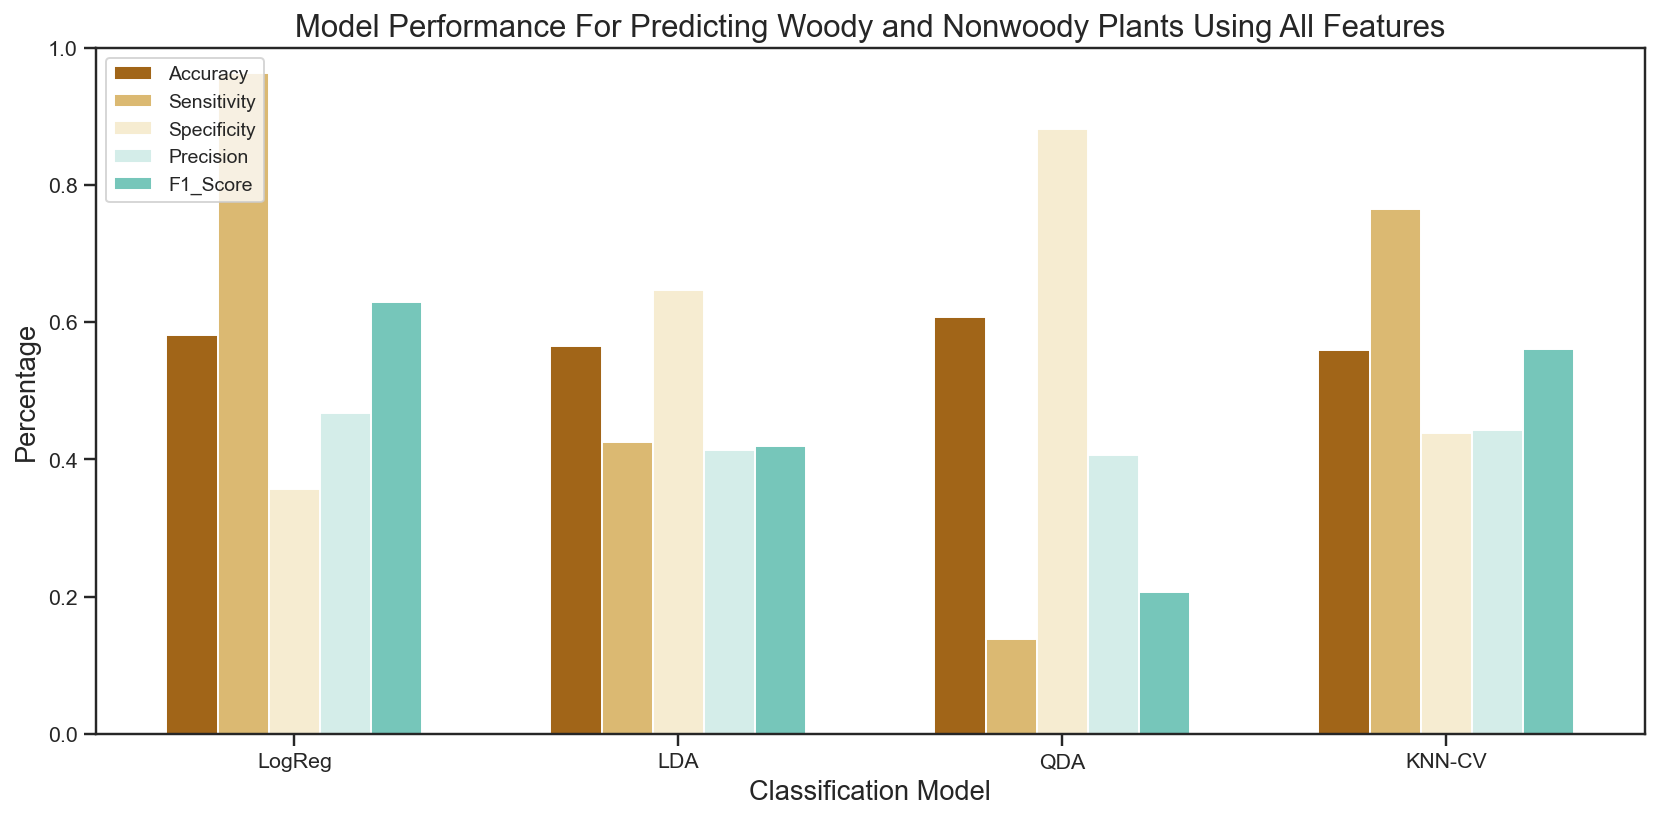

In [16]:
#Bar Graph
models = ['LogReg', 'LDA', 'QDA', 'KNN-CV']
print(models)
accuracies = statallfeatures_dic["Accuracy"]
print("Accuracies" + str(accuracies))
sensitivities = statallfeatures_dic["Sensitivity"]
print("Sen" + str(sensitivities))
specificities = statallfeatures_dic["Specificity"]
print("Spec" + str(specificities))
precisions = statallfeatures_dic["Precision"]
print("P" + str(precisions))
f1_scores = statallfeatures_dic["F1_Score"]
print("F1" + str(f1_scores))

x = 6*np.arange(len(models))
width = 0.8

fig, ax = plt.subplots(figsize=(12, 6))
import seaborn as sns
colors = sns.color_palette("BrBG")

acc = ax.bar(x-width*2, accuracies, width, label='Accuracy', color=colors[0])
sen = ax.bar(x-width, sensitivities, width, label='Sensitivity', color=colors[1])
spe = ax.bar(x,specificities, width, label='Specificity', color=colors[2])
pre = ax.bar(x+width, precisions, width, label='Precision', color=colors[3])
f1 = ax.bar(x+width*2 , f1_scores, width, label='F1_Score', color=colors[4])

ax.set_xlabel('Classification Model', fontsize=14)
ax.set_ylabel('Percentage', fontsize=14)
ax.set_title('Model Performance For Predicting Woody and Nonwoody Plants Using All Features', fontsize=16)
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()
ax.set(ylim=(0.0, 1))


fig.tight_layout()

plt.legend(loc="upper left", prop={'size': 10})
plt.show()

fig.savefig('AllFeaturesPerformance.png')

#Code from https://matplotlib.org/stable/gallery/lines_bars_and_markers/barchart.html#sphx-glr-gallery-lines-bars-and-markers-barchart-py

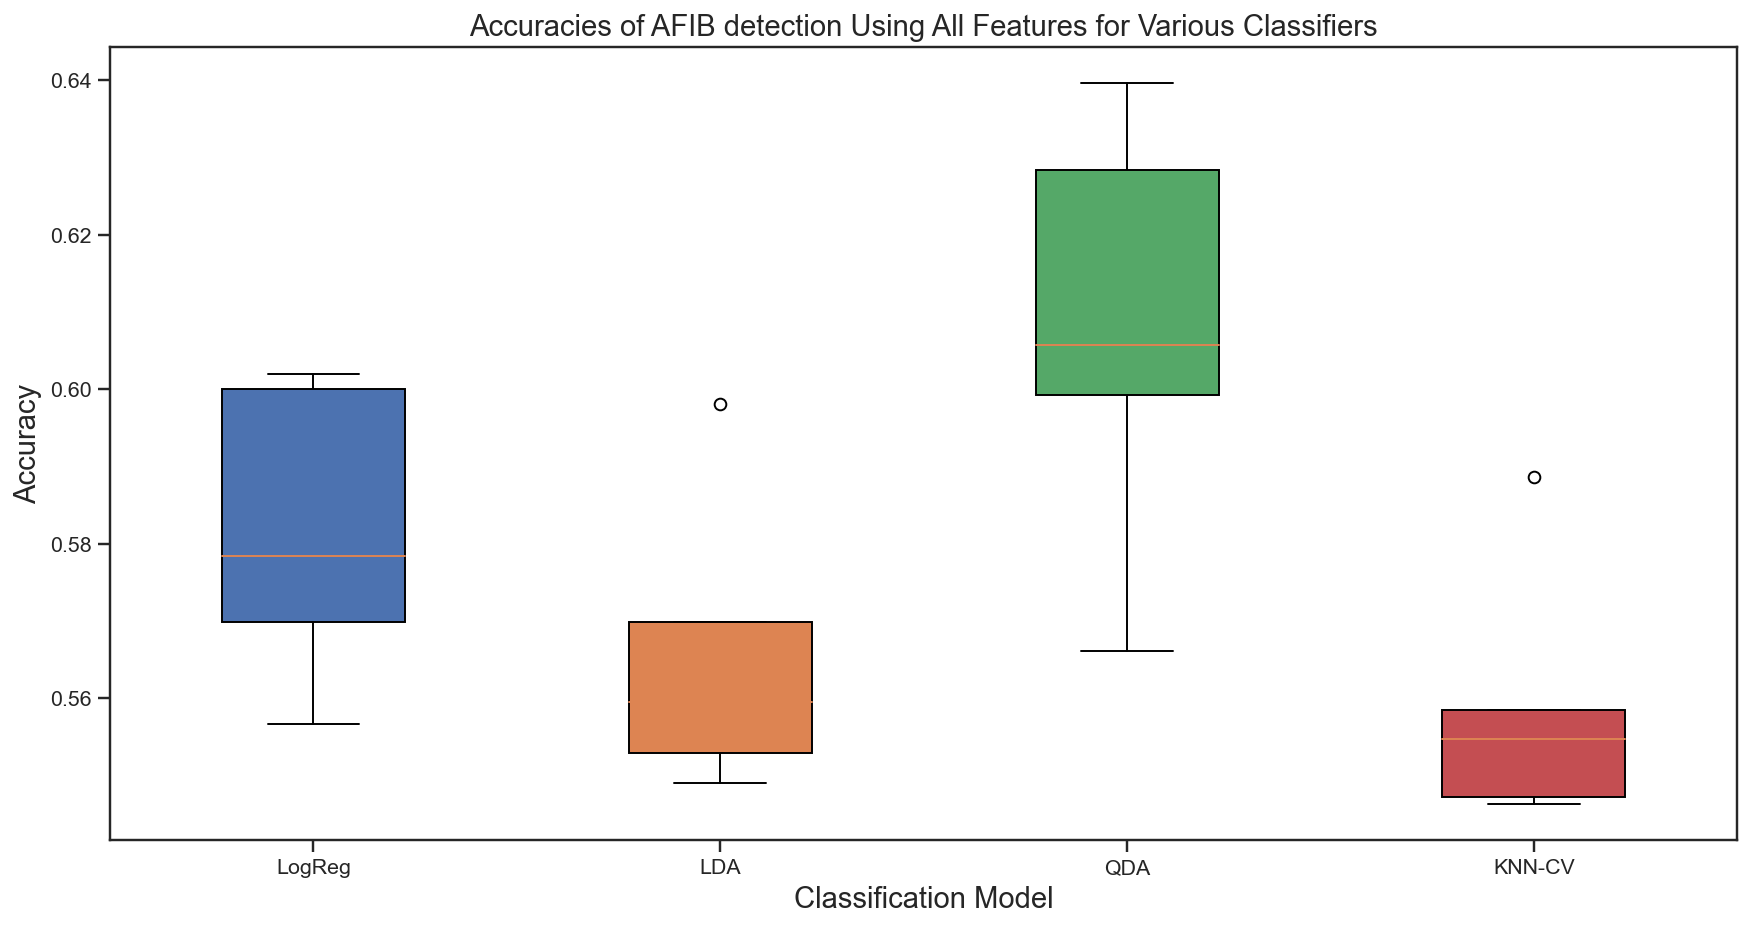

In [17]:
#Box Plot Accuracies

models = ['LogReg', 'LDA', 'QDA', 'KNN-CV']

x = np.arange(len(models))+1

LogRegAcc = indaccs_dic['LogReg']
LDAAcc = indaccs_dic['LDA']
QDAAcc = indaccs_dic['QDA']
KNNAcc = indaccs_dic['KNN']

data = [LogRegAcc, LDAAcc, QDAAcc, KNNAcc]

fig, ax = plt.subplots(figsize = (15,7.5))
bplot = ax.boxplot(data, patch_artist = True)

ax.set_title('Accuracies of AFIB detection Using All Features for Various Classifiers', fontsize=15)
ax.set_xlabel('Classification Model', fontsize=15)
ax.set_ylabel('Accuracy', fontsize=15)
ax.set_xticks(x)
ax.set_xticklabels(models)

import seaborn as sns
#colors = sns.color_palette("colorblind")
colors = sns.color_palette()

for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)
plt.show()

In [18]:
"""
print("Log reg act: " + str(needed))
print("Log reg pred: " + str(FWC4))
print("QDA act: " + str(needed2))
print("QDA pred: " + str(FWC2))
print("LDA act: " + str(needed3))
print("LDA pred: " + str(FWC))
print("KNN act: " + str(needed4))
print("KNN pred: " +str(FWC3))
Logerrorrate = abs((needed-FWC4)/needed) *100
QDAerrorrate = abs((needed-FWC2)/needed) *100
LDAerrorrate = abs((needed-FWC)/needed) *100
KNNerrorrate = abs((needed-FWC3)/needed) *100

print("log ER = " + str(Logerrorrate))
print("QDA ER = " + str(QDAerrorrate))
print("LDA ER = " + str(LDAerrorrate))
print("KNN ER = " + str(KNNerrorrate))
"""

'\nprint("Log reg act: " + str(needed))\nprint("Log reg pred: " + str(FWC4))\nprint("QDA act: " + str(needed2))\nprint("QDA pred: " + str(FWC2))\nprint("LDA act: " + str(needed3))\nprint("LDA pred: " + str(FWC))\nprint("KNN act: " + str(needed4))\nprint("KNN pred: " +str(FWC3))\nLogerrorrate = abs((needed-FWC4)/needed) *100\nQDAerrorrate = abs((needed-FWC2)/needed) *100\nLDAerrorrate = abs((needed-FWC)/needed) *100\nKNNerrorrate = abs((needed-FWC3)/needed) *100\n\nprint("log ER = " + str(Logerrorrate))\nprint("QDA ER = " + str(QDAerrorrate))\nprint("LDA ER = " + str(LDAerrorrate))\nprint("KNN ER = " + str(KNNerrorrate))\n'